In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import sys
import os
# Add the directory to sys.path
datasets_dir = '/dtu/blackhole/16/155094/Video_classification'
sys.path.append(datasets_dir)
from datasets import FrameImageDataset, FrameVideoDataset

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
batch_size = 64

# Dataset directories
root_dir = '/dtu/blackhole/16/155094/ufc101'

# Initialize datasets
train_dataset = FrameVideoDataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = FrameVideoDataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = FrameVideoDataset(root_dir=root_dir, split='test', transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Initialize the model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = len(train_dataset.df['label'].unique())
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes) # Vi laver et fully connected lag med 10 kategorier 
model._fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Add dropout with probability 0.5
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [45]:
import timm
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=10, input_channels= 3):
        super(EfficientNetModel, self).__init__()
        
        
        self.first_layer = nn.Sequential(
            nn.Conv2d(input_channels, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=00)  # Remove final layer
        self.backbone.eval()  # Freeze EfficientNet layers if desired
        
        # Add shared fully connected layers after feature extraction
        self.shared_fc = nn.Linear(1280 , 256)  # 1280 output channels from EfficientNet-B0


    def forward(self, x):
        # Extract features using EfficientNet
        x = self.first_layer(x)
        features = self.backbone(x)
        # shared_features = self.shared_fc(features)
        
        # # Output classification and bounding box predictions
        # class_out = self.classifier(shared_features)
        
        return features

In [46]:
class Simple_CNN(nn.Module):
    def __init__(self, dropOutVal=0.2, num_classes=10, input_channels = 3):
        super(Simple_CNN, self).__init__()

        # Convolutional Feature Extraction
        self.network = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Dropout2d(dropOutVal),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
        )
        # Classification Head
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(12544, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes) 
        )
        

    def forward(self, x):
        features = self.network(x).view(x.size(0), -1) # Flatten
        
        class_out = self.classifier(features)
        
        return class_out


    


In [50]:
# Initialize the model

# model = Simple_CNN(input_channels =3*train_dataset.n_sampled_frames, dropOutVal=0.4)
# model = EfficientNetModel(input_channels =3*train_dataset.n_sampled_frames)
# model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# # Metrics storage
# train_loss_history = []
# val_loss_history = []
# train_acc_history = []
# val_acc_history = []

# Training and Validation Loop
epochs = 10
for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    

    for videos, labels in train_loader:
        shape_0 = videos.shape[0]
        shape_1 = videos.shape[1]
        shape_2 = videos.shape[2]
        shape_3 = videos.shape[3]
        shape_4 = videos.shape[4]
        
        videos, labels = videos.to(device), labels.to(device)

        videos = videos.view(shape_0,shape_1*shape_2, shape_3,shape_4)
        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            shape_0 = videos.shape[0]
            shape_1 = videos.shape[1]
            shape_2 = videos.shape[2]
            shape_3 = videos.shape[3]
            shape_4 = videos.shape[4]

            videos, labels = videos.to(device), labels.to(device)
            videos = videos.view(shape_0,shape_1*shape_2, shape_3,shape_4)

            outputs = model(videos)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print metrics
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


Epoch [1/10]
Train Loss: 2.2313, Train Accuracy: 93.80%
Val Loss: 2.4472, Val Accuracy: 85.83%
Epoch [2/10]
Train Loss: 2.0994, Train Accuracy: 94.00%
Val Loss: 2.3714, Val Accuracy: 85.83%
Epoch [3/10]
Train Loss: 2.0713, Train Accuracy: 94.80%
Val Loss: 2.3934, Val Accuracy: 88.33%
Epoch [4/10]
Train Loss: 2.0657, Train Accuracy: 94.60%
Val Loss: 2.3543, Val Accuracy: 87.50%
Epoch [5/10]
Train Loss: 1.9654, Train Accuracy: 95.40%
Val Loss: 2.2760, Val Accuracy: 86.67%
Epoch [6/10]
Train Loss: 2.1108, Train Accuracy: 94.60%
Val Loss: 2.2962, Val Accuracy: 87.50%
Epoch [7/10]
Train Loss: 1.9502, Train Accuracy: 95.40%
Val Loss: 2.2519, Val Accuracy: 86.67%
Epoch [8/10]
Train Loss: 2.0565, Train Accuracy: 96.00%
Val Loss: 2.2233, Val Accuracy: 88.33%
Epoch [9/10]
Train Loss: 2.0568, Train Accuracy: 94.60%
Val Loss: 2.1888, Val Accuracy: 88.33%
Epoch [10/10]
Train Loss: 1.9242, Train Accuracy: 95.60%
Val Loss: 2.1817, Val Accuracy: 90.00%


In [51]:
torch.save(model,"effinet_model_b0_early_fusion.pkl")

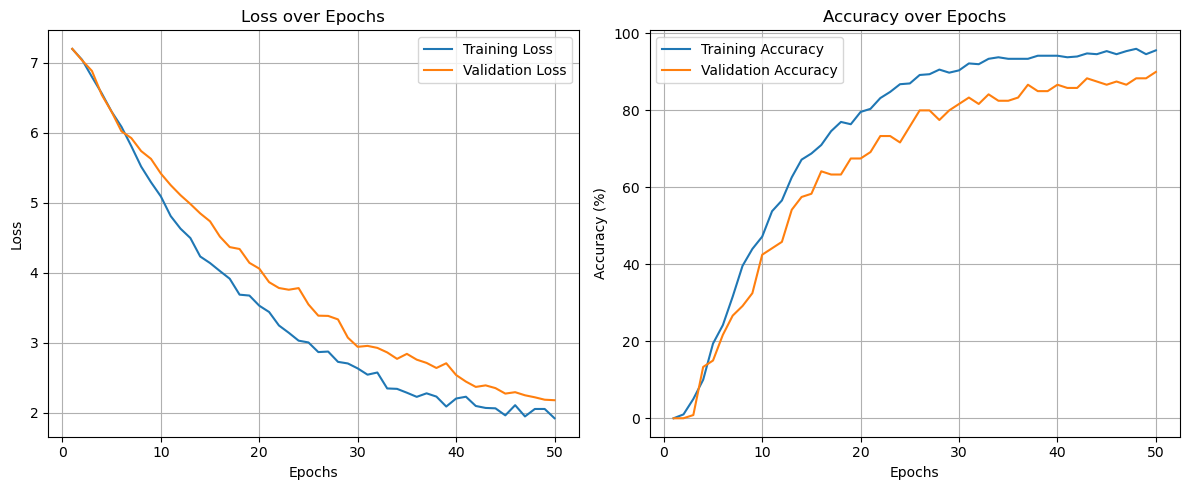

In [54]:
# Plotting Loss over Epochs
epochs_range = range(1, len(train_loss_history) +1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [55]:
# Validation
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for videos, labels in test_loader:
        shape_0 = videos.shape[0]
        shape_1 = videos.shape[1]
        shape_2 = videos.shape[2]
        shape_3 = videos.shape[3]
        shape_4 = videos.shape[4]

        videos, labels = videos.to(device), labels.to(device)
        videos = videos.view(shape_0,shape_1*shape_2, shape_3,shape_4)

        outputs = model(videos)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

val_loss /= len(val_loader)
val_acc = 100 * correct / total


# Print metrics
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%")

Test Loss: 1.9318, Test Accuracy: 91.67%
